# Automatic Twitter Event Summarization: Making Sense of War in Ukraine
---
**Aishwarya Kale and William Simpson** \
Dept. of Computer Science & Electrical Engineering, University of Maryland, Baltimore County \
DATA 690: Introduction to Natural Language Processing \
Dr. Antonio Diana \
May 6, 2022

# Install Necessary Libraries

In [1]:
!pip install -q bertopic
!pip install -q python-louvain
!pip install -q -U sentence-transformers
!pip install -q transformers
!pip install -q rouge
!pip install -q emoji
!pip install -q pandarallel 
!pip install -q sumy
!pip install -q textrank4zh
!pip install -q textstat

In [145]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt') 
from datetime import datetime, timedelta
import ast

# ner
from spacy import displacy
import emoji
import string

# topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from bertopic import BERTopic

# clustering
from sklearn.metrics.pairwise import linear_kernel
from tqdm.notebook import tnrange
import networkx as nx
import community.community_louvain as community_louvain
from sentence_transformers import SentenceTransformer, util
import umap
import hdbscan
from bertopic import BERTopic
from gensim.summarization import keywords
from wordcloud import WordCloud

# sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob as tb
nltk.download('vader_lexicon')
from pandarallel import pandarallel

# summarization
from transformers import pipeline
from rouge import Rouge 
from statistics import mean
import seaborn as sns
import math
from collections import Counter
from nltk.probability import FreqDist
from sentence_transformers.util import cos_sim as cos_sim_
import transformers
from transformers import BartTokenizer, BartForConditionalGeneration
import textwrap
from gensim.summarization import summarize
from spacy.lang.en.stop_words import STOP_WORDS
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from string import punctuation
from heapq import nlargest
import sys
from textrank4zh import TextRank4Sentence
import textstat

# settings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=DeprecationWarning)
import multiprocessing
# check number of cores available
print('\nNUMBER OF CPU CORES:', multiprocessing.cpu_count())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

NUMBER OF CPU CORES: 4


# Data Preparation

IMPORTANT:

1) The filepath may need to be changed to point to the location of the datafile.\
2) The lineterminator='\n' parameter is necessary to ensure Pandas reads the file correctly.

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load original data file for custom preprocessing in NER and Sentiment Analysis
tweets_original = pd.read_csv('/content/drive/MyDrive/Ukraine_war.csv')

# load cleaned data 
tweets = pd.read_csv('/content/drive/MyDrive/ukraine_war_clean_.csv', lineterminator='\n')

In [5]:
# view original file
tweets_original.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,Searh
0,snscrape.modules.twitter.Tweet,https://twitter.com/ksenijapavlovic/status/150...,2022-03-05 23:59:58+00:00,There was an anti war protest for #Ukraine as ...,There was an anti war protest for #Ukraine as ...,1500259859937337349,"{'_type': 'snscrape.modules.twitter.User', 'us...",2,4,25,0,1500259859937337349,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,['https://twitter.com/Reuters/status/150013026...,['https://t.co/CTulO2hTsA'],"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...",NaN,NaN,NaN,NaN,NaN,['Ukraine'],NaN,Ukraine war
1,snscrape.modules.twitter.Tweet,https://twitter.com/ty_phoon31/status/15002598...,2022-03-05 23:59:58+00:00,https://t.co/Z1pURKlNHu NATO followed USA into...,abc.net.au/news/2022-03-0… NATO followed USA i...,1500259857160568834,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1500259857160568834,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,['https://www.abc.net.au/news/2022-03-05/nato-...,['https://t.co/Z1pURKlNHu'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ukraine war
2,snscrape.modules.twitter.Tweet,https://twitter.com/ann_peace22/status/1500259...,2022-03-05 23:59:54+00:00,@mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...,@mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...,1500259841520111616,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1500182315112321028,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,NaN,NaN,NaN,NaN,NaN,1.500182e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,['IStandWithUkraine'],NaN,Ukraine war
3,snscrape.modules.twitter.Tweet,https://twitter.com/GardensR4Health/status/150...,2022-03-05 23:59:52+00:00,@nytimes This war could have been avoided by e...,@nytimes This war could have been avoided by e...,1500259833915883525,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,0,1499516258781437953,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.499516e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Ukraine war
4,snscrape.modules.twitter.Tweet,https://twitter.com/kbrunolieber/status/150025...,2022-03-05 23:59:52+00:00,@ggreenwald Remember the biggest mistake made ...,@ggreenwald Remember the biggest mistake made ...,1500259832649203713,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,2,0,1500195950136020993,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,1.500200e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Ukraine war


In [6]:
# view cleaned data
tweets.head()

,content,date,content_clean,tokenized,tokens_no_stopwords,token_sents_no_stops,lemmatized_no_stops,lemmatized_sent_no_stops
0,There was an anti war protest for #Ukraine as ...,2022-03-05 23:59:58+00:00,there was an anti war protest for ukraine as w...,"['there', 'was', 'an', 'anti', 'war', 'protest...","['anti', 'war', 'protest', 'ukraine', 'well', ...",anti war protest ukraine well getting headline...,"['anti', 'war', 'protest', 'ukraine', 'well', ...",anti war protest ukraine well headline serbia ...
1,https://t.co/Z1pURKlNHu NATO followed USA into...,2022-03-05 23:59:58+00:00,nato followed usa into afghanistan forgotten a...,"['nato', 'followed', 'usa', 'into', 'afghanist...","['nato', 'followed', 'usa', 'afghanistan', 'fo...",nato followed usa afghanistan forgotten alread...,"['nato', 'follow', 'usa', 'afghanistan', 'forg...",nato follow usa afghanistan forget already tri...
2,@mfa_russia @RusEmbUSA @RussiaUN @MFA_Ukraine ...,2022-03-05 23:59:54+00:00,it s not russophobia we just hate putin and al...,"['it', 's', 'not', 'russophobia', 'we', 'just'...","['russophobia', 'hate', 'putin', 'enablers', '...",russophobia hate putin enablers russian people...,"['russophobia', 'hate', 'putin', 'enablers', '...",russophobia hate putin enablers russian people...
3,@nytimes This war could have been avoided by e...,2022-03-05 23:59:52+00:00,this war could have been avoided by ensuring t...,"['this', 'war', 'could', 'have', 'been', 'avoi...","['war', 'could', 'avoided', 'ensuring', 'putin...",war could avoided ensuring putin ukraine could...,"['war', 'could', 'avoid', 'ensure', 'putin', '...",war could avoid ensure putin ukraine could joi...
4,@ggreenwald Remember the biggest mistake made ...,2022-03-05 23:59:52+00:00,remember the biggest mistake made by those who...,"['remember', 'the', 'biggest', 'mistake', 'mad...","['remember', 'biggest', 'mistake', 'made', 'su...",remember biggest mistake made supported afghan...,"['remember', 'big', 'mistake', 'make', 'suppor...",remember big mistake make support afghanistan ...


In [7]:
# convert to datetime object
tweets.date = pd.to_datetime(tweets.date)

In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199480 entries, 0 to 199479
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   content                   199480 non-null  object             
 1   date                      199480 non-null  datetime64[ns, UTC]
 2   content_clean             199480 non-null  object             
 3   tokenized                 199480 non-null  object             
 4   tokens_no_stopwords       199480 non-null  object             
 5   token_sents_no_stops      199480 non-null  object             
 6   lemmatized_no_stops       199480 non-null  object             
 7   lemmatized_sent_no_stops  199480 non-null  object             
dtypes: datetime64[ns, UTC](1), object(7)
memory usage: 12.2+ MB


### Group Tweets by Time

In [9]:
# get range of dates in corpus
last_date = tweets.date.max().date() + timedelta(days=1)
first_date = tweets.date.min().date()
date_range = pd.date_range(start=first_date, end=last_date)
date_range

DatetimeIndex(['2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31',
               '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04',
               '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08',
               '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12',
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
      

In [10]:
# function to group tweets by selected time interval
def tweets_by_time_interval(data=None, interval=2, just_groups=False):
  """
  Parameters:
    data: dataframe (tweets)
    interval: int (number of days in each time interval)
    just_groups: bool (return only the groupings of dates)

  Returns:
    date_groups: list
    tweets_date: dataframe
  """
  selected_interval = interval
  date_groups = list(zip(*(iter(date_range),) * selected_interval))
  if just_groups:
    return date_groups
  tweets_date = []
  for i in date_groups:
    start = str(i[0].to_pydatetime())
    end = str(i[-1].to_pydatetime() + timedelta(days=1))
    tweets_date.append(data.loc[(data.date > start) & (data.date <= end)])
  return tweets_date

In [11]:
# define function to remove emojis
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

---
---
# Part 1. Sub-event and Main Idea Detection




## 1.1. Named Entity Recognition



In [12]:
# load the model
NER = spacy.load("en_core_web_sm")

In [13]:
# get data
tweets_ = tweets.copy()
# convert to datetime object
tweets_.date = pd.to_datetime(tweets_['date']).dt.date
# select relevant columns
tweets_ = tweets_[['date', 'token_sents_no_stops']]

In [14]:
tweets_.head()

,date,token_sents_no_stops
0,2022-03-05,anti war protest ukraine well getting headline...
1,2022-03-05,nato followed usa afghanistan forgotten alread...
2,2022-03-05,russophobia hate putin enablers russian people...
3,2022-03-05,war could avoided ensuring putin ukraine could...
4,2022-03-05,remember biggest mistake made supported afghan...


In [15]:
combined_df = tweets_.groupby('date', as_index=False)['token_sents_no_stops'].apply('.'.join)

In [16]:
combined_df.head()

,date,token_sents_no_stops
0,2021-12-31,us want russia ukraine fight proxy war supply ...
1,2022-01-01,purpose whitewashing russian bellicose stance ...
2,2022-01-02,hilarious kremlin propaganda bullshit could st...
3,2022-01-03,imagine putin xi mullahs simultaneously making...
4,2022-01-04,avert war west welcome ukraine reformed russia...


In [17]:
# define function for NER
def get_NER(raw_text, len_):
  text1= NER(raw_text)
  for word in text1.ents[:len_]:
    print(word.text,word.label_)

In [18]:
# output sample NER
raw_text = combined_df['token_sents_no_stops'].values[0]
get_NER(raw_text, 25)

us GPE
russia GPE
ukraine GPE
ukraine GPE
russia GPE
vietnam GPE
afghanistan GPE
russian NORP
russia nato ORG
eastern europe LOC
russia GPE
russia GPE
russia GPE
first.putin GPE
ukraine GPE
russia GPE
ukraine GPE
russia GPE
vietnam GPE
afghanistan GPE
european NORP
ukraine GPE
russia GPE
new year EVENT
ukraine GPE


In [19]:
# visualize NER
text1= NER(raw_text)
displacy.render(text1,style="ent",jupyter=True)

## 1.2. Topic Modeling

### 1.2.1. Non-negative Matrix Factorization (NMF)

In [20]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 2)
date_groups = tweets_by_time_interval(tweets, 2, True)

for i,group in enumerate(tweets_date):
  print(f'DATES: {date_groups[i][0].date()} - {date_groups[i][-1].date()}')
  # vectorize 
  vect = TfidfVectorizer(max_features=2000, min_df=1)
  X = vect.fit_transform(group.lemmatized_sent_no_stops)
  # get dictionary
  idx_to_word = np.array(vect.get_feature_names_out())

  # nmf 
  nmf = NMF(n_components=5, solver="mu")
  W = nmf.fit_transform(X)
  H = nmf.components_

  # print topics
  for i, topic in enumerate(H):
    # terms in each topic are in descending order of importance/contribution to that topic
    print(f'Topic {i+1}: {",".join([str(x) for x in idx_to_word [topic.argsort()[:-10:-1]]])}')
    total = topic.sum()
  print('\n')

DATES: 2021-12-31 - 2022-01-01
Topic 1: russia,ukraine,war,border,invade,nato,start,europe,us
Topic 2: putin,biden,call,sanction,complete,phone,via,president,joe
Topic 3: russian,ukraine,civil,war,ukrainian,invasion,force,soldier,eastern
Topic 4: year,new,happy,begin,hope,midnight,straight,invade,calendar
Topic 5: china,usa,taiwan,world,nato,nuclear,know,war,need


DATES: 2022-01-02 - 2022-01-03
Topic 1: russia,ukraine,war,invade,china,via,nuclear,us,taiwan
Topic 2: biden,key,avoid,moscow,see,act,decisively,interest,national
Topic 3: putin,sanction,make,vladimir,great,world,warn,must,think
Topic 4: russian,aggression,occupy,wages,threaten,frame,territory,already,ukrainian
Topic 5: nato,war,ukraine,people,one,like,country,cold,think


DATES: 2022-01-04 - 2022-01-05
Topic 1: russia,ukraine,war,putin,start,invade,china,like,nuclear
Topic 2: top,diplomat,visit,frontline,moscow,back,solidarity,show,force
Topic 3: pentagon,ex,syria,us,lobby,conflict,fuel,advisor,via
Topic 4: nato,avert,join,

In [21]:
# view numerical contribution of top terms to a subset of topics -- for last date range
for topic, words in enumerate(H):
  total = words.sum()
  largest = words.argsort()[::-1]
  print(f'\nTopic {topic}')
  for i in range(3):
    print(idx_to_word[largest[i]], round(words[largest[i]], 4))


Topic 0
ukraine 1.688
war 1.6567
russia 0.8059

Topic 1
putin 1.9358
declaration 0.8537
sanction 0.6269

Topic 2
russia 1.6386
via 0.9209
news 0.6746

Topic 3
nato 2.1587
fly 0.3447
zone 0.3167

Topic 4
world 1.8656
war 0.2275
via 0.2001


### 1.2.2. BERTopic

##### 1.2.2.1. BERTopic Word Scores

In [22]:
# most salient words/terms in each topic

def get_BERTopic_word_scores(data, date_group_, group_num):
  """
  Parameters:
    data: dataframe
    date_group_: list (time intervals)
    group_num: int (selected period of x days)

  Returns:
    topic_modeling.visualize_barchart()
  """
  group = group_num
  print(f'DATES: {date_group_[group][0].date()} - {date_group_[group][-1].date()}')
  sentence_vects = list(data[group]['lemmatized_sent_no_stops'])
  topic_modeling = BERTopic(n_gram_range=(1,3), min_topic_size=40)
  topics, probs = topic_modeling.fit_transform(sentence_vects)
  return(topic_modeling.visualize_barchart())

In [23]:
# Generate data with specified number of days in each interval
# TOPICS ACROSS ENTIRE DATASET
tweets_date = tweets_by_time_interval(tweets, 65)
date_groups = tweets_by_time_interval(tweets, 65, True)
get_BERTopic_word_scores(tweets_date, date_groups, 0)

DATES: 2021-12-31 - 2022-03-05


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [24]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 7)
date_groups = tweets_by_time_interval(tweets, 7, True)
# Topic word scores for a sample subset of data
get_BERTopic_word_scores(tweets_date, date_groups, 5)

DATES: 2022-02-04 - 2022-02-10


In [25]:
# Topic word scores for a sample subset of data
get_BERTopic_word_scores(tweets_date, date_groups, 7)

DATES: 2022-02-18 - 2022-02-24


In [26]:
# Topic word scores for a sample subset of data
get_BERTopic_word_scores(tweets_date, date_groups, -1)

DATES: 2022-02-25 - 2022-03-03


#### 1.2.2.2. BERTopic Intertopic Distance Figure

In [27]:
# intertopic distance

def get_BERTopic_dist(data, date_group_, group):
  """
  Parameters:
    data: dataframe
    date_group_: list (time intervals)
    group: int (selected period of x days)

  Returns:
    topic_modeling.visualize_topics()
  """
  date_group_ix = group
  sentence_vects = list(data[date_group_ix]['lemmatized_sent_no_stops'])
  topic_modeling = BERTopic(n_gram_range=(1,3), min_topic_size=70)
  topics, probs = topic_modeling.fit_transform(sentence_vects)
  print(f'{date_group_[date_group_ix][0].date()} - {date_group_[date_group_ix][-1].date()}')
  return topic_modeling.visualize_topics()

In [28]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 3)
date_groups = tweets_by_time_interval(tweets, 3, True)
get_BERTopic_dist(tweets_date, date_groups, 20)

2022-03-01 - 2022-03-03


#### 1.2.2.3. BERTopic Hierarchical Clustering

In [29]:
# visualize the hierarchy of related topics

def get_BERTopic_hierarch(data, date_group_, group):
  """
  Parameters:
    data: dataframe
    date_group_: list (time intervals)
    group: int (selected period of x days)

  Returns:
    topic_modeling.visualize_hierarchy()
  """
  date_group_ix = group
  sentence_vects = list(data[date_group_ix]['lemmatized_sent_no_stops'])
  topic_modeling = BERTopic(n_gram_range=(1,3), min_topic_size=70)
  topics, probs = topic_modeling.fit_transform(sentence_vects)
  print(f'{date_group_[date_group_ix][0].date()} - {date_group_[date_group_ix][-1].date()}')
  return topic_modeling.visualize_hierarchy(orientation='left')

In [30]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 5)
date_groups = tweets_by_time_interval(tweets, 5, True)
get_BERTopic_hierarch(tweets_date, date_groups, 4)

2022-01-20 - 2022-01-24


#### 1.2.2.4. BERTopic Topics over time

In [31]:
# visualize how topics change over time

def get_BERTopic_over_time(data, date_group_, group):
  """
  Parameters:
    data: dataframe
    date_group_: list (time intervals)
    group: int (selected period of x days)

  Returns:
    topic_modeling.visualize_topics_over_time()
  """
  date_group_ix = group
  sentence_vects = list(data[date_group_ix]['lemmatized_sent_no_stops'])
  topic_modeling = BERTopic(n_gram_range=(1,3), min_topic_size=70)
  topics, probs = topic_modeling.fit_transform(sentence_vects)
  print(f'{date_group_[date_group_ix][0].date()} - {date_group_[date_group_ix][-1].date()}')

  timestamps = list(data[date_group_ix]['date'])

  topics_over_time = topic_modeling.topics_over_time(sentence_vects, topics, timestamps, nr_bins=20)
  return topic_modeling.visualize_topics_over_time(topics_over_time, top_n_topics=10)

In [32]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 7)
date_groups = tweets_by_time_interval(tweets, 7, True)
get_BERTopic_over_time(tweets_date, date_groups, 7)

2022-02-18 - 2022-02-24


In [33]:
# Generate data with specified number of days in each interval
tweets_date = tweets_by_time_interval(tweets, 8)
date_groups = tweets_by_time_interval(tweets, 8, True)
get_BERTopic_over_time(tweets_date, date_groups, -1)

2022-02-25 - 2022-03-04


## 1.3. Clustering

### 1.3.1. Network Graph with Cosine Similarity

In [34]:
# tweets by date
tweets_date = tweets_by_time_interval(tweets, 1)
date_groups = tweets_by_time_interval(tweets, 1, True)
# get subset of tweets
group_num = 32
selected_tweets = tweets_date[group_num]

In [35]:
# compute tfidf
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
X = tf.fit_transform(selected_tweets['content_clean'])

In [36]:
# cos sim matrix -- using linear kernal from sklearn which is the same as cosine_similarity when using tfidf, but faster
# source: https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

sim_matrix = linear_kernel(X, X)

In [37]:
matrix_with_cos_sim = [sim_matrix]
data_sets = [selected_tweets['content_clean']]

top_n_sentences = []
for cs, t in zip(matrix_with_cos_sim, data_sets):
    no_dups = np.array(t)
    i = 0
    top_frame = []
    for c, z in zip(cs, tnrange(len(cs))):
        # Create vector of tweets
        start_name = pd.Series([no_dups[i]]*3) 
        # Index of top 3 similar tweets
        ix_top_n = np.argsort(-c)[0:3]
        cos_sim = pd.Series(c[ix_top_n])
        names = pd.Series(no_dups[ix_top_n])
        i += 1
        top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
    top_frame = pd.concat(top_frame)
    top_frame.columns = ['tweet1', 'tweet2', 'cos_sim']
    # Remove the similarities for the same sentences
    top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['tweet1'], top_frame['tweet2'])]
    top_frame = top_frame[top_frame['is_same'] != True]
        
    top_n_sentences.append(top_frame)

  0%|          | 0/3852 [00:00<?, ?it/s]

In [38]:
top_frame

,tweet1,tweet2,cos_sim,is_same
1,the sky is the limit for the pm flying the fla...,kay burley has continually bolstered johnson u...,0.126033,False
2,the sky is the limit for the pm flying the fla...,the pm s off to ukraine on a diplomatic missio...,0.072288,False
1,kinda following this russia ukraine pissin mat...,does the uk know what they went to war in agha...,0.068154,False
2,kinda following this russia ukraine pissin mat...,russia is willing to go to war and incur sanct...,0.056375,False
1,that doesn t answer the question of what exact...,russia is willing to go to war and incur sanct...,0.082225,False
...,...,...,...,...
2,nobody is asking for american troops to fight ...,nobody is asking for american troops to fight ...,0.912952,False
1,nobody s asking the us to fight this war for u...,reality no american wants to go to war for ukr...,0.124123,False
2,nobody s asking the us to fight this war for u...,rep tom malinowksi nobody is asking for americ...,0.111881,False
1,how are russian media outlets portraying the u...,it s not the same you re an idiot russia doesn...,0.11137,False


In [39]:
# define graph structure
top_frame = top_n_sentences[0] 
edges = list(zip(top_frame['tweet1'], top_frame['tweet2']))
weighted_edges = list(zip(top_frame['tweet1'], top_frame['tweet2'], top_frame['cos_sim']))
nodes = list(set(top_frame['tweet1']).union(set(top_frame['tweet2'])))

In [40]:
# get graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [41]:
# get community partitions
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)

2022-02-01 - 2022-02-01


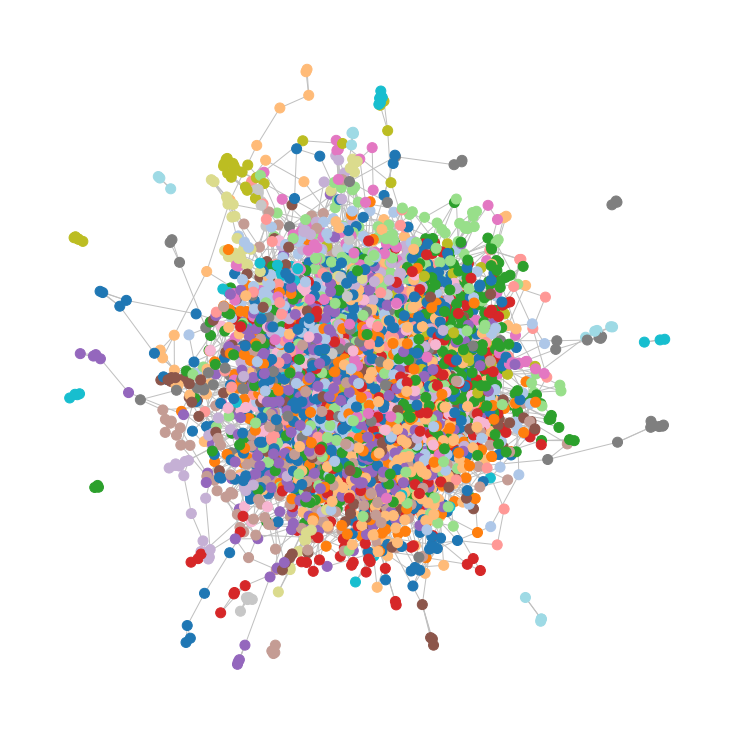

In [42]:
# create graph
print(f'{date_groups[group_num][0].date()} - {date_groups[group_num][-1].date()}')
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=100, with_labels=False)

In [43]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [44]:
top_clust = frame_clust.groupby('Cluster').count().sort_values('Title', ascending=False)[:3]
top_clust

,Title
Cluster,
14,237
29,175
2,173


In [45]:
# prepare sub-graph
largest_clusters = list(top_clust.index)
nodes_in_select_community = [node for node,community in partition.items() if community in largest_clusters]
sub_G = G.subgraph(nodes_in_select_community)
nodes_in_select_community2 = [(community,node) for node,community in partition.items() if community in largest_clusters]

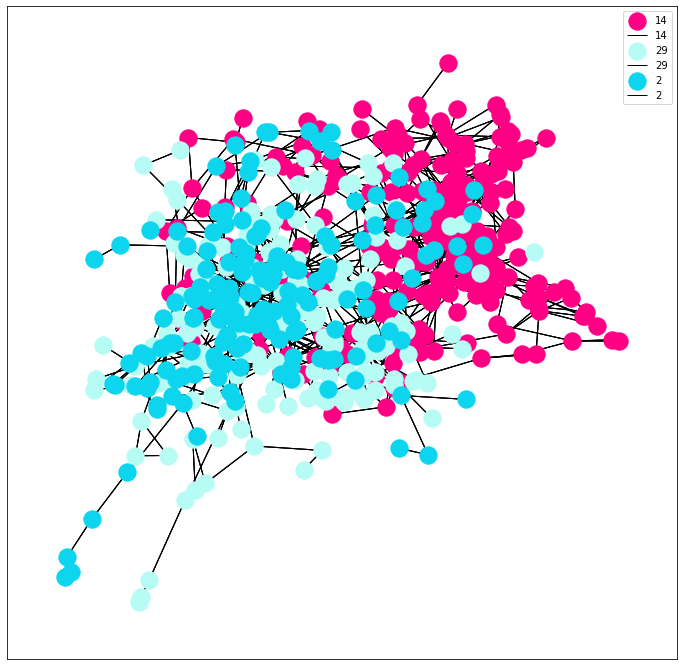

In [46]:
node_type = largest_clusters
node_color = ['#ff0085', '#b6fcf5', '#0ed5ee', '#d189f9', '#b98501', '#380568', '#9b07a8', '#ff8000']
nodeTypeDict = dict(zip(node_type, []))
nodeColorDict = dict(zip(node_type, node_color))

fig, ax = plt.subplots(1, figsize=(12,12))

for idx, cluster_num in enumerate(node_type):
  nodelist = []
  for i in range(len(nodes_in_select_community2)):
    if nodes_in_select_community2[i][0] == cluster_num:
      nodelist.append(nodes_in_select_community2[i][1])
  nodecolor = node_color[idx]
  nx.draw_networkx(sub_G, 
                           pos=pos,
                           nodelist=nodelist,
                           ax=ax, 
                           cmap=plt.cm.brg, 
                           vmin=0.0,
                           vmax=1.0,
                           node_color=nodecolor,
                           label=cluster_num,
                           with_labels=False)
plt.legend(scatterpoints=1)
plt.show()

### 1.3.2. Clustering with Transformers

#### 1.3.2.1. Create Embeddings

In [47]:
# get sentences for vectorization/embedding

# keep stops for embedding
sentence_vects = list(tweets['content_clean'])
# create batches to avoid OOM errors in clustering
sentence_vects1 = sentence_vects[:55000]
sentence_vects2 = sentence_vects[55000:110000]
sentence_vects3 = sentence_vects[110000:165000]
sentence_vects4 = sentence_vects[165000:]

In [48]:
# load pre-trained sentence embeddings, run with GPU
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [49]:
# get sentence embeddings -- in batches
tweet_embeddings1 = model.encode(sentence_vects1, batch_size=32, show_progress_bar=True, convert_to_tensor=True)
tweet_embeddings2 = model.encode(sentence_vects2, batch_size=32, show_progress_bar=True, convert_to_tensor=True)
tweet_embeddings3 = model.encode(sentence_vects3, batch_size=32, show_progress_bar=True, convert_to_tensor=True)
tweet_embeddings4 = model.encode(sentence_vects4, batch_size=32, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/1719 [00:00<?, ?it/s]

Batches:   0%|          | 0/1719 [00:00<?, ?it/s]

Batches:   0%|          | 0/1719 [00:00<?, ?it/s]

Batches:   0%|          | 0/1078 [00:00<?, ?it/s]

In [50]:
# get clusters
clusters1 = util.community_detection(tweet_embeddings1, min_community_size=25, threshold=0.75)
clusters2 = util.community_detection(tweet_embeddings2, min_community_size=25, threshold=0.75)
clusters3 = util.community_detection(tweet_embeddings3, min_community_size=25, threshold=0.75)
clusters4 = util.community_detection(tweet_embeddings4, min_community_size=25, threshold=0.75)

In [51]:
# see clusters from batch 1:
for i, cluster in enumerate(clusters1):
  print('Cluster', i)
  for elem in cluster[:10]:
    print(sentence_vects[elem])

Cluster 0
the war between ukraine and russia
war between russia and ukraine
ukraine and russia war
some war with ukraine and russia
russia ukraine war
ukraine russian war
just the war between russia and ukraine
a russian war with ukraine rather
what war ukraine russia
the war in ukraine russiaukraine
Cluster 1
ukraine is not a nato member you just want to start another war
nato to ukraine you re on your own now we don t want another world war
ukraine cannot join nato because it is still at war
wise woman we need end war ukraine can join europe union but not nato
ukraine is not part of nato if we help there will be a nuclear war
for the sake of peace ukraine should not be allowed to join nato otherwise world war is starting
why would they attack ukraine is not a member of nato nobody wants a war
i m talking about our european nato allies they don t want war ukraine isn t in nato
if ukraine is apart of nato you should have already been there but if not they would be declaring war on russ

#### 1.3.2.2. Visualize with Wordclouds of Clusters

In [52]:
all_cluster_list = []
for i, cluster in enumerate(clusters1):
  cluster_list = []
  #print('Cluster', i)
  for elem in cluster:
    cluster_list.append(sentence_vects[elem])
    #print(sentence_vects[elem])
  all_cluster_list.append(cluster_list)
cluster_df = pd.DataFrame(all_cluster_list)

In [53]:
# make the columns the separate clusters and the rows the individual tweets under that cluster
cluster_df = cluster_df.T

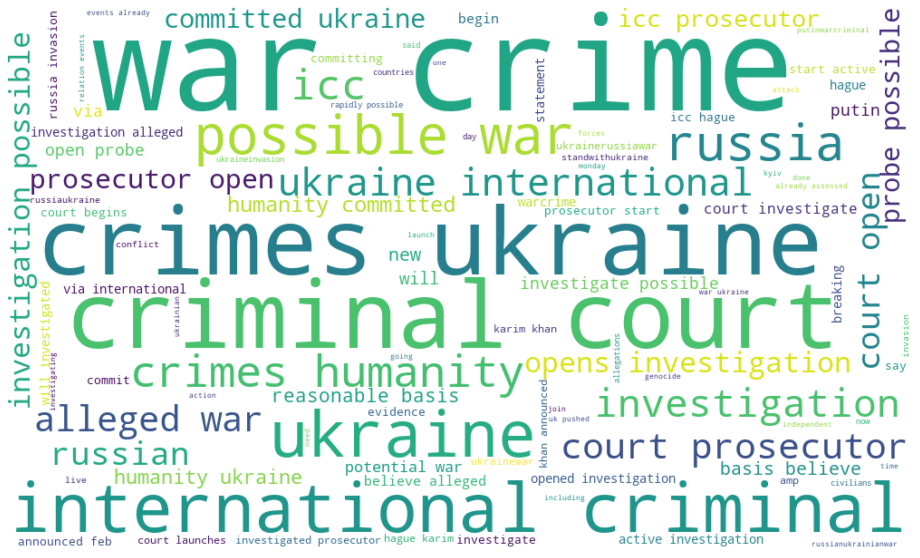

In [54]:
# create wordcloud for a sample cluster
text = cluster_df[3].loc[~cluster_df[3].isna()]
text = " ".join([row for row in text])
wordcloud = WordCloud(max_words=100, background_color="white", width=1000, height=600).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

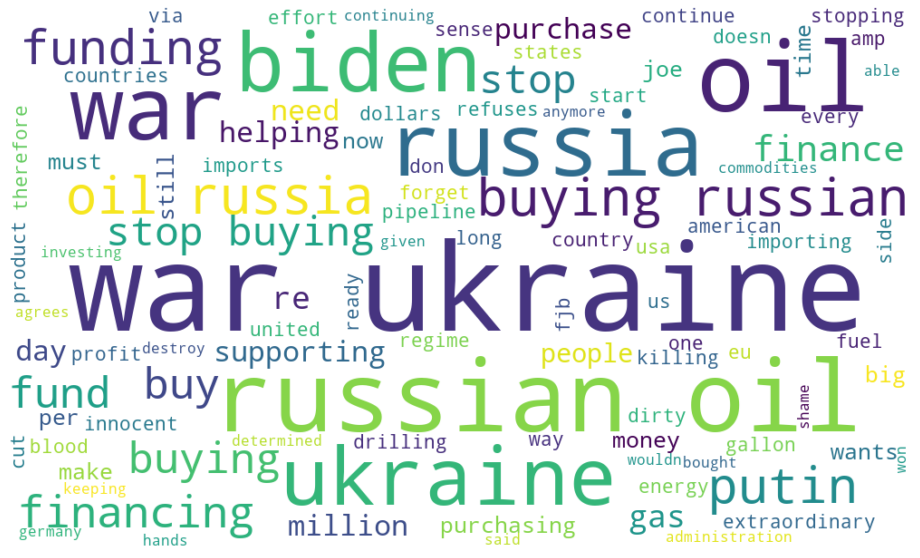

In [55]:
# create wordcloud for a sample cluster
text = cluster_df[15].loc[~cluster_df[15].isna()]
text = " ".join([row for row in text])
wordcloud = WordCloud(max_words=100, background_color="white", width=1000, height=600).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

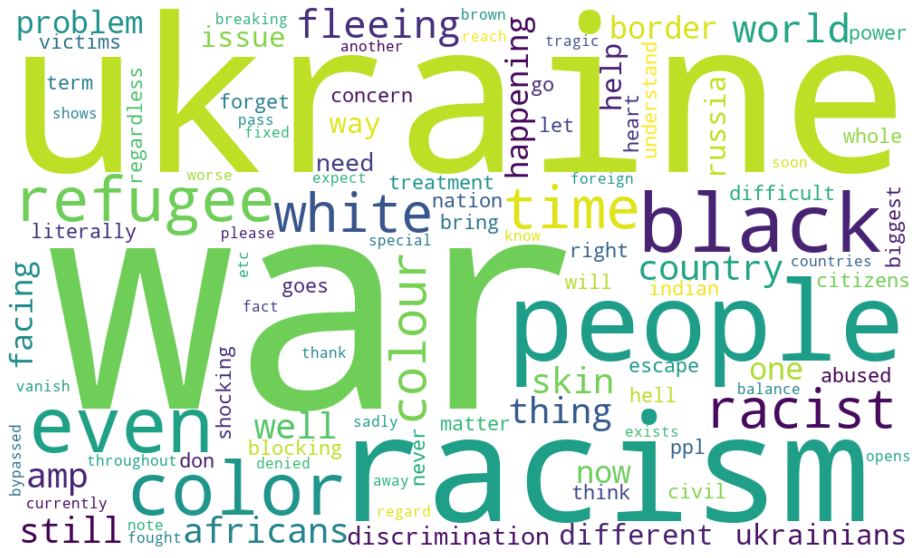

In [56]:
# create wordcloud for a sample cluster
text = cluster_df[25].loc[~cluster_df[25].isna()]
text = " ".join([row for row in text])
wordcloud = WordCloud(max_words=100, background_color="white", width=1000, height=600).generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 1.3.2.3. Keywords from Clusters

In [57]:
# get keywords from clusters
keywords_by_cluster = []
for i in range(cluster_df.shape[1]):
  text = cluster_df[i].loc[~cluster_df[i].isna()]
  text = " ".join([row for row in text])
  kw = keywords(text).split('\n')[2:17]
  keywords_by_cluster.append(kw)
keywords_by_cluster

[['war',
  'wars',
  'russia',
  'russias',
  'russian',
  'putin',
  'russians invaded',
  'ukrainian',
  'ukrainians',
  'new',
  'news',
  'ukrainerussiawar ukrainewar ukraineinvasion russiaukraineconflict',
  'conflict',
  'conflicts',
  'ukrainerussianwar'],
 ['war',
  'wars',
  'nato member',
  'countries',
  'country',
  'russia got',
  'putin invaded',
  'want',
  'wants',
  'wanting',
  'wanted',
  'nuclear',
  'start',
  'starting',
  'started'],
 ['peace no_war',
  'pray',
  'praying',
  'world war peacenotwar',
  'lets prays',
  'prayers',
  'prayerful',
  'peaceful',
  'russia prayer',
  'amp',
  'god',
  'people',
  'peoples',
  'stop',
  'stops'],
 ['crime',
  'international',
  'icc',
  'investigated',
  'investigate',
  'investigating',
  'investigations',
  'investigators',
  'alleged war crimes',
  'news',
  'new',
  'opens investigation',
  'prosecutor',
  'russia invasion',
  'committed'],
 ['ukraine',
  'russia',
  'russian',
  'russians',
  'nato jets shooting',


## 1.4. Sentiment Analysis

### 1.4.1. Data Cleaning and Preparation

In [63]:
# get data
tweets_ = tweets.copy()
# convert dates column into datetime format
tweets_.date = pd.to_datetime(tweets_['date']).dt.date
# get relevant columns
tweets_ = tweets_[['content','date', 'content_clean']]

In [64]:
# defining a lambda function to combine tweets
combine_tweets = lambda text: ".".join(text)

In [65]:
# combining tweets for same day
combined_tweets = tweets_.groupby(by='date').agg({'content_clean': combine_tweets}).reset_index()

In [66]:
pd.set_option('max_colwidth', 1000)
combined_tweets.head()

,date,content_clean
0,2021-12-31,the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you a...
1,2022-01-01,what is the purpose of whitewashing russian bellicose stance justifying russian threats all while it is russia that wages war of agression in ukraine which has already taken more than lives and forced millions of ukrainians to become internally displaced fleeing the war.what is the purpose of mental gymnastics to position russia as a threatened side again it was russia that started the war in ukraine and continues attacks in ukrainian military from russian occupied ukrainian territory.war drums uss harry s truman carrier group ordered to stay in mediterranean as tensions rise between russia ukraine.what happened next both nazi germany and ussr as allies simultaneously invaded poland and started ww now we have a situation when russia invaded ukraine in and wages war of aggression on ukraine for years noone else is willing to invade ukraine why the false analogies.do the separatists in ukraine count what is their problem anyway why do they want autonomy do they have russian citizensh...
2,2022-01-02,hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the hum...
3,2022-01-03,imagine putin xi and the mullahs simultaneously making their moves the biden administration and our woke military will lose a multi theater war tough to be ukraine skorea taiwan or iraq.the whole article is interesting even if the part on cyber is a bit hand wavy but particularly intriguing is the discussion of the armenia azerbaijan war and cheap drones bear meet porcupine unconventional deterrence for ukraine via.putin is trying to establish a new cold war our sanctions have not been enough to deter russia if putin invades ukraine it will be bloody it seems like putin is deadset on it.so finland has joined the queue along with countries using ukraine as a pretext to join nato guess there are benefits if war crimes and genocides are the tools of your trade i guess we ll need russia and china more than ever now to counter us nato opportunism and aggression.i don t do predictions but this is facts remember when the 

#### 1.4.1.1. Combining tweets grouped by two days

In [67]:
# defining column names
col_names = list(tweets_.columns)
print('column names:\n',col_names)

# initializing an empty dataframe with those column names
comb_tweets_2d = pd.DataFrame(columns=col_names)

column names:
 ['content', 'date', 'content_clean']


In [68]:
# get range of dates 
end = tweets_.date.max() + timedelta(days=1)
begin = tweets_.date.min()
all_date = pd.date_range(start=begin, end=end)
all_date

DatetimeIndex(['2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31',
               '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04',
               '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08',
               '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12',
               '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16',
               '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
      

In [69]:
# make groups of 2 days
dateList = list(all_date)
N = 2
subdateList = [dateList[n:n+N] for n in range(0, len(dateList), N)]
subdateList

[[Timestamp('2021-12-31 00:00:00', freq='D'),
  Timestamp('2022-01-01 00:00:00', freq='D')],
 [Timestamp('2022-01-02 00:00:00', freq='D'),
  Timestamp('2022-01-03 00:00:00', freq='D')],
 [Timestamp('2022-01-04 00:00:00', freq='D'),
  Timestamp('2022-01-05 00:00:00', freq='D')],
 [Timestamp('2022-01-06 00:00:00', freq='D'),
  Timestamp('2022-01-07 00:00:00', freq='D')],
 [Timestamp('2022-01-08 00:00:00', freq='D'),
  Timestamp('2022-01-09 00:00:00', freq='D')],
 [Timestamp('2022-01-10 00:00:00', freq='D'),
  Timestamp('2022-01-11 00:00:00', freq='D')],
 [Timestamp('2022-01-12 00:00:00', freq='D'),
  Timestamp('2022-01-13 00:00:00', freq='D')],
 [Timestamp('2022-01-14 00:00:00', freq='D'),
  Timestamp('2022-01-15 00:00:00', freq='D')],
 [Timestamp('2022-01-16 00:00:00', freq='D'),
  Timestamp('2022-01-17 00:00:00', freq='D')],
 [Timestamp('2022-01-18 00:00:00', freq='D'),
  Timestamp('2022-01-19 00:00:00', freq='D')],
 [Timestamp('2022-01-20 00:00:00', freq='D'),
  Timestamp('2022-01-21 

In [70]:
# make dataframe having start date , end date and combined two days tweets
df_comb2_tweets = pd.DataFrame(columns=['content','date1','date2'])
for i in subdateList:
  date1,date2 = i[0],i[1]
  #tweets_date_ = pd.DataFrame(columns=['text'])
  filter1 = combined_tweets['content_clean'].loc[(combined_tweets.date == date1)].values
  filter2 = combined_tweets['content_clean'].loc[(combined_tweets.date == date2)].values
  v2 = np.concatenate([filter1,filter2])
  df_comb2_tweets = df_comb2_tweets.append({'content' : v2, 'date1' : date1, 'date2' : date2},ignore_index = True)

In [71]:
# displaying data
df_comb2_tweets.head(2)

,content,date1,date2
0,[the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you ...,2021-12-31,2022-01-01
1,[hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the hu...,2022-01-02,2022-01-03


In [72]:
# converting object to string
df_comb2_tweets = df_comb2_tweets.astype({"content": str})
df_comb2_tweets.head(2)

,content,date1,date2
0,['the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you...,2021-12-31,2022-01-01
1,['hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the h...,2022-01-02,2022-01-03


### 1.4.2. Textblob

In [73]:
# rename columns
df_comb2_tweets = df_comb2_tweets.rename(columns={'content':'content_clean'})

In [74]:
# evaluate sentiment
df_comb2_tweets['polarity'] = df_comb2_tweets['content_clean'].apply(lambda x: tb(x).sentiment.polarity)
df_comb2_tweets['subjectivity'] = df_comb2_tweets['content_clean'].apply(lambda x: tb(x).sentiment.subjectivity)
  
df_comb2_tweets.head(10)

,content_clean,date1,date2,polarity,subjectivity
0,['the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you...,2021-12-31,2022-01-01,0.040928,0.423296
1,['hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the h...,2022-01-02,2022-01-03,0.029276,0.456600
2,['to avert war the west should welcome ukraine and a reformed russia into nato i like this idea.russian hybrid forced launched attacks in the war zone in e ukraine over the last h official empr russiaukrainewar.this is potentially politically destabilising for central asia and in particular russia who are on the cusp on war with ukraine how is this not being reported by and.the best explanation forget the cheese let s get out of the trap ending the threat of war in ukraine a negotiated solution to the donbas conflict and the crimean dispute quincy institute for responsible statecraft.you morons are so easily led this photo is real but does not show journalists or doctors in nuremberg germany rather it captures the moment nazi officers were executed for war crimes in kyiv ukraine read a freaking history book before posting ignorant stuff.seeking is fine but with their wish to be in nato as you ve stated they want to be under the american national security umbrella at least be honest...,2022-01-04,2022-01-05,0.046338,0.420943
3,['color revolution ukraine syria lybia iraq etc just the same game but beware the russian bear we saw what happened in syria expect a swift solution to this situation without all out got war thank you russia.the current black swans i could see occurring are the ray dalio style debt bubble bursting or a war with russia due to the conflict in ukraine i don t think the fed let s the former occur tho.america has no business in kazakhstan or ukraine nobody cares what russia does i know you want war but it isn t going to happen.jp kasim analysis risky power play in eastern europe could trigger war clashes on the border with poland gas crisis military uprising around ukraine tensions are rising in eastern europe and the risk of open conflict is present.think of it as putin s card hand in global energy war as one axis o

In [75]:
# rename columns
df_comb2_tweets = df_comb2_tweets.rename(columns={'polarity':'TextBlob_polarity','subjectivity':'TextBlob_subjectivity'})

### 1.4.3. VADER



In [76]:
# intialize parallel computation
pandarallel.initialize(nb_workers=4, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [77]:
# define sentiment analysis function with VADER
def vader_sent(row):
  return SentimentIntensityAnalyzer().polarity_scores(row)

In [78]:
sentimentList = df_comb2_tweets['content_clean'].parallel_apply(vader_sent)

In [79]:
# converting the sentiment values to a dataframe
sentiment_df = pd.DataFrame.from_dict(list(sentimentList))
sentiment_df.head(10)

,neg,neu,pos,compound
0,0.251,0.658,0.090,-1.0
1,0.249,0.654,0.097,-1.0
2,0.243,0.661,0.097,-1.0
3,0.255,0.654,0.091,-1.0
4,0.245,0.667,0.089,-1.0
5,0.247,0.661,0.091,-1.0
6,0.265,0.648,0.087,-1.0
7,0.261,0.651,0.088,-1.0
8,0.263,0.656,0.081,-1.0
9,0.252,0.657,0.090,-1.0


In [80]:
# adding the sentiment values to orginial dataframe
df_comb2_tweets['neg'],df_comb2_tweets['neu'],df_comb2_tweets['pos'],df_comb2_tweets['compound'] = sentiment_df['neg'], sentiment_df['neu'], sentiment_df['pos'], sentiment_df['compound'] 

df_comb2_tweets.head(10)

,content_clean,date1,date2,TextBlob_polarity,TextBlob_subjectivity,neg,neu,pos,compound
0,['the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you...,2021-12-31,2022-01-01,0.040928,0.423296,0.251,0.658,0.090,-1.0
1,['hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the h...,2022-01-02,2022-01-03,0.029276,0.456600,0.249,0.654,0.097,-1.0
2,['to avert war the west should welcome ukraine and a reformed russia into nato i like this idea.russian hybrid forced launched attacks in the war zone in e ukraine over the last h official empr russiaukrainewar.this is potentially politically destabilising for central asia and in particular russia who are on the cusp on war with ukraine how is this not being reported by and.the best explanation forget the cheese let s get out of the trap ending the threat of war in ukraine a negotiated solution to the donbas conflict and the crimean dispute quincy institute for responsible statecraft.you morons are so easily led this photo is real but does not show journalists or doctors in nuremberg germany rather it captures the moment nazi officers were executed for war crimes in kyiv ukraine read a freaking history book before posting ignorant stuff.seeking is fine but with their wish to be in nato as you ve stated they want to be under the american national security umbrella at least be honest...,2022-01-04,2022-01-05,0.046338,0.420943,0.243,0.661,0.097,-1.0
3,['color revolution ukraine syria lybia iraq etc just the same game but beware the russian bear we saw what happened in syria expect a swift solution to this situation without all out got war thank you russia.the current black swans i could see occurring are the ray dalio style debt bubble bursting or a war with russia due to the conflict in ukraine i don t think the fed let s the former occur tho.america has no business in kazakhstan or ukraine nobody cares what russia does i know you want war but it isn t going to happen.jp kasim analysis risky power play in eastern europe could trigger war clashes on the border with poland gas crisis military uprising around ukraine tensions are rising in eastern europe 

In [81]:
# assigning the tweets as negative, positive, compound 
sntmnt = []
for index, row in df_comb2_tweets.iterrows():
    neg = row['neg']
    neu = row['neu']
    pos = row['pos']
    compound = row['compound']
    if compound >= 0:
        snt = "positive"
    elif compound <=  0:
        snt = "negative"
    else:
        snt = "neutral"
    sntmnt.append(snt)

In [82]:
# assigning the created list to original dataframe
df_comb2_tweets['Vader_sentiment'] = sntmnt

In [83]:
positive = df_comb2_tweets[df_comb2_tweets['Vader_sentiment'] == 'positive']
negative = df_comb2_tweets[df_comb2_tweets['Vader_sentiment'] == 'negative']
neutral  = df_comb2_tweets[df_comb2_tweets['Vader_sentiment'] == 'neutral']

In [84]:
len(positive),len(negative),len(neutral)

(0, 33, 0)

#### Tweets are predominantly negative

In [85]:
sentiment_df.head()

,neg,neu,pos,compound
0,0.251,0.658,0.090,-1.0
1,0.249,0.654,0.097,-1.0
2,0.243,0.661,0.097,-1.0
3,0.255,0.654,0.091,-1.0
4,0.245,0.667,0.089,-1.0


#### Plotting the sentiment analysis over time grouped by 2 days

In [86]:
data = df_comb2_tweets.copy()

In [87]:
# Set type of polarity
polarity = []

for i in range(len(data)):
    if (data['compound'][i] < 0):
        polarity.append("Negative")
    elif (data['compound'][i] > 0):
        polarity.append("Positive")
    else:
        polarity.append("Neutral")
    
polarity = pd.DataFrame(polarity)
data['Polarity'] = polarity
data.tail()

,content_clean,date1,date2,TextBlob_polarity,TextBlob_subjectivity,neg,neu,pos,compound,Vader_sentiment,Polarity
28,['a ukrainian citizen has part of his leg torn off by shrapnel from a russian explosive war is a terrible thing even more so when you re a regular citizen who did nothing to cause this chaos ukraine ukrainerussia ukraineunderattack ukraineinvasion ucrainia kyiv nato usa.after the war i ll be visiting ukraine because i m bowled over by the resilience charm humility and courage of the ukrainian people and that s a country i want to visit ukraine.stop the war in ukraine russia learn something from china they don t go for land they win hearts and minds with investment everywhere in the world.ukraine animal shelter could use your support now please donate if you can vegan at the edge of war crowdfunding support and retweet.if doesn t get involved still it s a disaster u let down a country that trusted u world will laugh at us it s just a sanctioning superpower joe gave hollow promises that they will protect ukraine now he is peeing his pants at the sight of war putin on rampage coz of c...,2022-02-25,2022-02-26,0.027189,0.458544,0.255,0.635,0.110,-1.0,negative,Negative
29,['i don t remember any war or any political issue with the entire world united on supporting ukraine amp honestly it s fucking moving the world might not fight but they sure stand with us slava ukraini.blue island podcast war ukraine.we re climbing up the escalation latter folks ukraine needs these jets and supplying them is sound policy but it should also cause many of us to update our priors on the possibility of this war spilling over to formally include nato.eu is not at war the planes will be delivered from eu but ukraine army pilots will fly them like others have said as long as eu soldiers are not participating is legit.i don t live in europe or the usa but my country is in the west and i don t want to go to war friend my country is already at war hours a day days a year u can put the death toll of ukraine and russia at the end of the war and you won t have the death toll in year.if thats the case where putin is all foam and no beer why doesn t the world step in to help figh...,2022-02-27,2022-02-28,0.027871,0.448537,0.256,0.638,0.106,-1.0,negative,Negative
30,['but putin will wipe out ukraine and then move on the nato countries we will eventually get into this war the only question is how many ukrainian people have to die before it happens.i agree with you on alot but not this the greatest generation didnt sit on the sidelines we sent our best to fight to save europe we need to do the same now if nuclear war breaks out it s still a better option than to lose ukraine the breadbasket of the world.you get the tucker carlsons and donald trumps doing your job for you the fact that putin managed to persuade trump that ukraine belongs to russia and that trump would be willing to give up ukraine without any kind of fight that s a major success for putin s information war.do you really think there would be war in ukraine if donald trump hadn t been president.bolsonaro does not represent me the brazilian don t want war we are with ukraine stop the ukrainerussiawar peaceforukraine.horrible war destruction suffering pain human loss we are witnessin...,2022-03-01,2022-03-02,0.023255,0.448966,0.287,0.617,0.096,-1.0,negative,Negative
31,['the intercept controlled pseudo opposition ratting out sources for almost as long as the ukraine war has been going on but tankies.this yes this is why there is war in ukraine we really have lost the plot with this woke bullshit wake up ffs.amp just like that america s taken the lead shutting down all russian media now the eu needs to step up propaganda is a covert weapon of war putin uses rt america permanently shuts down us operations lays off staff as russia ukraine crisis escalates.putin would use nukes risk of wider war even if contained the war between nato and russia would destroy ukraine just don t want to risk fig

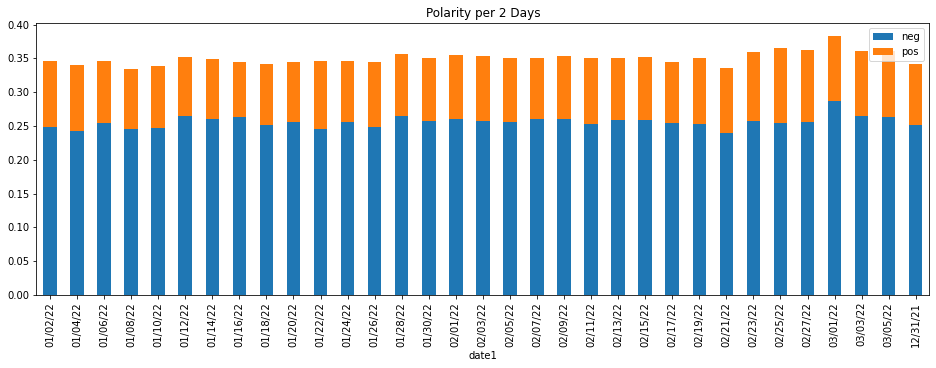

In [88]:
data['date1'] = pd.to_datetime(data['date1'])
data['date1'] = data['date1'].dt.strftime('%D')

x = data[['date1', 'neg', 'pos']]
y = x.set_index('date1')
z = y.groupby('date1').mean()

z.plot.bar(stacked=True, title='Polarity per 2 Days', figsize=(16,5))
plt.show()

--- 
---
# Part 2. Event Summarization and Performance Evaluation

## 2.1. Abstractive Text Summarization

### 2.1.1. Custom data preparation

In [89]:
tweets_ = tweets.copy()

In [90]:
# convert to datetime object
tweets_.date = pd.to_datetime(tweets_['date']).dt.date

In [91]:
# tweet counts
tweets_counts = tweets_.groupby(['date']).size().reset_index(name='counts')

In [92]:
# defining a lambda function to combine tweets
combine_tweets = lambda text: ".".join(text)

In [93]:
# combining tweets for same day
combined_tweets = tweets_.groupby(by='date').agg({'content_clean': combine_tweets}).reset_index()
combined_tweets.head()

,date,content_clean
0,2021-12-31,the us want russia in ukraine so they can fight them in a proxy war they will supply ukraine equipment maybe thru other nations and watch russia get stuck into a grind similar to vietnam or afghanistan a serious war like that will shatter the russian military.after the cold war the usa made guarantees to russia that nato wouldn t expand to eastern europe can t blame russia for drawing a line at ukraine.nato really wants to lure russia to war with ukraine nato should stop provoking russia won t attack first.if putin moves in ukraine he wins but at a cost to russia future ukraine will fight into a quagmire and russia doesn t have the youth population to replace their army after a bloody vietnam afghanistan type war.look forward to seeing you propagandists end up in the docket in the hague on war crimes charges.i didn t know that the term european theater was still in use lol i mean there s the ukraine russia war but still.happy new year s ukraine i want you to know i still love you a...
1,2022-01-01,what is the purpose of whitewashing russian bellicose stance justifying russian threats all while it is russia that wages war of agression in ukraine which has already taken more than lives and forced millions of ukrainians to become internally displaced fleeing the war.what is the purpose of mental gymnastics to position russia as a threatened side again it was russia that started the war in ukraine and continues attacks in ukrainian military from russian occupied ukrainian territory.war drums uss harry s truman carrier group ordered to stay in mediterranean as tensions rise between russia ukraine.what happened next both nazi germany and ussr as allies simultaneously invaded poland and started ww now we have a situation when russia invaded ukraine in and wages war of aggression on ukraine for years noone else is willing to invade ukraine why the false analogies.do the separatists in ukraine count what is their problem anyway why do they want autonomy do they have russian citizensh...
2,2022-01-02,hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the hum...
3,2022-01-03,imagine putin xi and the mullahs simultaneously making their moves the biden administration and our woke military will lose a multi theater war tough to be ukraine skorea taiwan or iraq.the whole article is interesting even if the part on cyber is a bit hand wavy but particularly intriguing is the discussion of the armenia azerbaijan war and cheap drones bear meet porcupine unconventional deterrence for ukraine via.putin is trying to establish a new cold war our sanctions have not been enough to deter russia if putin invades ukraine it will be bloody it seems like putin is deadset on it.so finland has joined the queue along with countries using ukraine as a pretext to join nato guess there are benefits if war crimes and genocides are the tools of your trade i guess we ll need russia and china more than ever now to counter us nato opportunism and aggression.i don t do predictions but this is facts remember when the 

In [94]:
combined_tweets['date'] = pd.to_datetime(combined_tweets['date'], format='%Y-%m-%d')
tweets_counts['date'] =  pd.to_datetime(tweets_counts['date'],format='%Y-%m-%d')
combined_df = pd.merge(combined_tweets,tweets_counts,on='date')

### 2.1.2. Using T5 Transformers

In [95]:
summarizer = pipeline("summarization", model="t5-small", tokenizer='t5-base', framework='tf')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [96]:
def get_transformer_summary(cleaned_tweets):
    preprocess_text = str(cleaned_tweets)
    summary = summarizer(preprocess_text, max_length=300, min_length=10)
    return summary

In [97]:
# get the summary of tweets of a requested date.
def tweets_against_dates(given_date,functionName):
  combined_df['date'] = pd.to_datetime(combined_df['date'], format='%Y-%m-%d')
  sampled_tweets = combined_df.loc[combined_df['date']==given_date]
  sampled_tweets['content_clean'] = sampled_tweets['content_clean'].values[0][:1500]
  sampled_tweets['trans_summary'] = sampled_tweets['content_clean'].apply(functionName)
  sampled_tweets.reset_index(inplace=True, drop=True)
  return sampled_tweets

In [98]:
dated_tweets = tweets_against_dates('2022-01-02',get_transformer_summary)

In [99]:
pd.set_option('max_colwidth', 10000)
dated_tweets

,date,content_clean,counts,trans_summary
0,2022-01-02,hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the human race with a weak amp demented a coordinated russian invasion of ukraine amp a chinese invasion of taiwan can easily happen war is always a pretext for economic resets russia holds more gold than that is very telling.decisively explain that mr biden draw us a picture you tired of not having troops in a war there is no stomach in america for anything like a war but it would be good for business sorry ukraine either way you get trounced.putin will not invade ukraine but to stifle it creating a tense,286,[{'summary_text': 'kremlin propaganda bullshit i could start tweeting photos of nazi lovers .biden vows us to act decisively if russia invades ukraine . mr biden s statement the us will not get us into a nuclear war with russia .'}]


### 2.2.3. Using BART

In [100]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [101]:
def BART_summary(ARTICLE):
  print(ARTICLE)
  input_tokens = tokenizer.batch_encode_plus([ARTICLE], return_tensors='pt', max_length=1024,truncation=True)['input_ids']
  encoded_ids = model.generate(input_tokens,num_beams=4,length_penalty=2.0,max_length=150,min_length=50,no_repeat_ngram_size=3)
  summary = tokenizer.decode(encoded_ids.squeeze(), skip_special_tokens=True)
  summ = textwrap.fill(summary, 100)
  summ = summ.strip().replace("\n","")
  return summ

In [102]:
dated_tweets_BART = tweets_against_dates('2022-01-02',BART_summary)

hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the human r

In [103]:
pd.set_option('max_colwidth', 10000)
dated_tweets_BART.head()

,date,content_clean,counts,trans_summary
0,2022-01-02,hilarious kremlin propaganda bullshit i could start tweeting photos of russian nazi lovers what s the point the fools the fools the fools if you support the kremlin in its war against ukraine you support imperialism and as such british imperialism in ireland.biden vows us to act decisively if russia invades ukraine what s the meaning of biden s statement the us to act decisively if russia invade ukraine hopefully biden isn t going to get us into a nuclear war with russia because of ukraine or anyone else other than our own security.actually decentamericans are fully behind drawing a red line when it comes to putin we know they they have been waging a stealth war against us with your super willing help treasonweasel amp a real one against ukraine we owe them for standing up to tfg.hopefully we the people see through this war spin the deception and not hand them our vote russian collusion ukraine quid pro quo now ukraine invasion on and on.never underestimate the stupidity of the human race with a weak amp demented a coordinated russian invasion of ukraine amp a chinese invasion of taiwan can easily happen war is always a pretext for economic resets russia holds more gold than that is very telling.decisively explain that mr biden draw us a picture you tired of not having troops in a war there is no stomach in america for anything like a war but it would be good for business sorry ukraine either way you get trounced.putin will not invade ukraine but to stifle it creating a tense,286,biden vows us to act decisively if russia invades ukraine. decentamericans are fully behind drawinga red line when it comes to putin. we know they they have been waging a stealth war against us. weowe them for standing up to tfg.


## 2.2. Extractive Text Summarization

### 2.2.1. Custom data preparation


In [112]:
tweets_0 = tweets_original.copy()
# convert to datetime object
tweets_0['date'] =  pd.to_datetime(tweets_0['date'],format='%Y-%m-%d')
tweets_0.date = pd.to_datetime(tweets_0['date']).dt.date
gen_df = tweets_0.groupby('date', as_index=False)['content'].apply('.'.join)
gen_df.head(1)

date  \
0  2021-12-31   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [113]:
# clean tweets

def genism_clean_text(corpus):    
    corpus = [re.sub(r'@\w+','',tweet) for tweet in corpus]
        
    # remove amp 
    corpus = [re.sub(r'&amp','',tweet) for tweet in corpus]
    # remove hashtag symbols
    corpus = [re.sub(r'#','',tweet) for tweet in corpus]
    # remove twitter handles
    corpus = [re.sub(r'@[A-Za-z0-9_]+','',tweet) for tweet in corpus]
    # remove urls
    corpus = [re.sub(r'http\S+','',tweet) for tweet in corpus]  
    return corpus

gen_df['raw_content'] = genism_clean_text(gen_df.content)
# remove emojis
gen_df['raw_content']= gen_df['raw_content'].apply(lambda x: remove_emoji(x))
gen_df.head(1)

date  \
0  2021-12-31   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### 2.2.2. Gensim Summary

In [114]:
def genism_summary(cleaned_tweets):
  summ = summarize(cleaned_tweets, word_count=100)
  summ = summ.strip().replace("\n","")
  return summ

In [115]:
def tweets_against_dates_gen(given_date,functionName):
  # print(functionName)
  gen_df['date'] = pd.to_datetime(gen_df['date'], format='%Y-%m-%d')
  sampled_tweets = gen_df.loc[gen_df['date']==given_date]
  sampled_tweets['trans_summary'] = sampled_tweets['raw_content'].apply(functionName)
  return sampled_tweets

In [116]:
dated_tweets_genism = tweets_against_dates_gen('2022-01-02',genism_summary)
dated_tweets_genism.head()

date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.3. TextRank - using SUMY

In [117]:
def sumy_textRank_summarizer(cleaned_text):
    parser =PlaintextParser.from_string(cleaned_text,Tokenizer("english"))
    TR_summarizer = TextRankSummarizer()
    summary =TR_summarizer(parser.document,2)
    summary_list = [str(sentence) for sentence in summary]
    result = ' '.join(summary_list)
    return result

In [118]:
dated_tweets_sumy_TR = tweets_against_dates_gen('2022-01-02',sumy_textRank_summarizer)
dated_tweets_sumy_TR.head()

date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.4. LEX RANK - using SUMY

LexRank is another graph-based summarization approach. It's comparable to TextRank in that it's unsupervised. Between two sentences, LexRank employs Cosine similarity rather than Jaccard. For all of the sentences in the document, this similarity score will be utilized to create a weighted graph. LexRank also ensures that the topmost sentences aren't too similar to one another. LexRank is a graph-based algorithm that is simple to comprehend and use. Its outcomes aren't as semantic.

In [119]:
def sumy_Lex_summarizer(cleaned_text):
    parser =PlaintextParser.from_string(cleaned_text,Tokenizer("english"))
    lex_summarizer = LexRankSummarizer()
    summary = lex_summarizer(parser.document,3)
    summary_list = [str(sentence) for sentence in summary]
    result = ' '.join(summary_list)
    return result

In [120]:
dated_tweets_sumy_lex = tweets_against_dates_gen('2022-01-02',sumy_Lex_summarizer)
dated_tweets_sumy_lex.head()

date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.5. LSA - using SUMY

Latent Semantic Analysis is based on Singular value decomposition(SVD). It compresses the data into a lower-dimensional space. It accomplishes spatial decomposition and collects data in a single vector, with the amplitude of that singular vector indicating the relevance. LSA can extract semantically linked sentences, but its computation is time-consuming.

In [121]:
def sumy_LSA_summarizer(cleaned_text):
    parser =PlaintextParser.from_string(cleaned_text,Tokenizer("english"))
    summarizer_lsa = LsaSummarizer()
    summary = summarizer_lsa(parser.document,3)
    summary_list = [str(sentence) for sentence in summary]
    result = ' '.join(summary_list)
    return result

In [122]:
dated_tweets_sumy_LSA = tweets_against_dates_gen('2022-01-02',sumy_LSA_summarizer)
dated_tweets_sumy_LSA.head()

date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.6. Using SpaCy

In [123]:
def spacy_summarizer(text):
    per = 0.005
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    summary = summary.strip().replace("\n","")
    return summary

In [124]:
dated_tweets_spacy = tweets_against_dates_gen('2022-01-02',spacy_summarizer)
dated_tweets_spacy.head()

date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.7. Using textrank4zh

In [125]:
summaryList = list()
def TextRank4_summary(cleaned_text):
  tr4s = TextRank4Sentence()
  tr4s.analyze(text=cleaned_text, lower=True, source = 'all_filters')
  for item in tr4s.get_key_sentences(num=3):
    summaryList.append(item.sentence)
    summary=''.join(summaryList)
    summary = summary.strip().replace("\n","")

  return summary

In [126]:
dated_tweets_TextRank4 = tweets_against_dates_gen('2022-01-02',TextRank4_summary)
dated_tweets_TextRank4.head()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.053 seconds.
Prefix dict has been built successfully.


date  \
2 2022-01-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### 2.2.8. Measuring Overall Text Difficulty

In [127]:
def check_difficulty(cleaned_text):
  difficulty = textstat.flesch_reading_ease(cleaned_text)
  read_time = textstat.reading_time(cleaned_text, ms_per_char=70)
  count = textstat.lexicon_count(cleaned_text, removepunct=True)
  return difficulty,read_time,count

In [128]:
sampled_df = gen_df[gen_df['date']=='2022-01-02']
measuringList =sampled_df['raw_content'].apply(check_difficulty)
measuringList= measuringList.tolist()
print('Text difficulty -->',measuringList[0][0])
print('Text Read Time -->',measuringList[0][1])
print('Text Count word -->',measuringList[0][2])

Text difficulty --> 74.08
Text Read Time --> 3686.34
Text Count word --> 10599


Flesch reading ease score:
- 90-100 | Very Easy
- 80-89  | Easy
- 70-79  | Fairly Easy
- 60-69  | Standard
- 50-59  | Fairly Difficult
- 30-49  | Difficult
- <30    | Very Confusing

## 2.3. Evaluation with Similarity Metrics

### 2.3.1 Abstractive Summaries Evaluation with Similarity Metrics

#### 2.3.1.1. Load generated abstractive summaries of 5 days.



In [129]:
# reading all csv files as pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/Latest_Transfomer_summary.csv')

In [130]:
abstract_summaries = df.copy()

In [131]:
def clean_summary(text2):
  text2 = text2.replace('summary_text', '')
  text2= re.sub("[^A-Za-z0-9 .]", "", text2)
  return text2

abstract_summaries['trans_summary'] = abstract_summaries['trans_summary'].apply(clean_summary)

In [132]:
abstract_summaries.drop(columns=['Unnamed: 0'],inplace=True)

In [133]:
abstract_summaries.head()

date  \
0  2022-02-03   
1  2022-02-02   
2  2022-01-16   
3  2022-01-15   
4  2022-02-27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### 2.3.1.2. Similarity Metrics: Count Vectorizer with Cosine Similarity

In [134]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    words = WORD.findall(text)
    print(words)
    return Counter(words)

df = abstract_summaries.copy()
df['vector1']=df['content_clean'].apply(lambda x: text_to_vector(x)) 
df['vector2']=df['trans_summary'].apply(lambda x: text_to_vector(x)) 
abstract_summaries['cosine_similarity_CV']=df.apply(lambda x: get_cosine(x['vector1'],x['vector2']),axis=1)

Output hidden; open in https://colab.research.google.com to view.

In [136]:
pd.set_option('max_colwidth', 100)
abstract_summaries.head()

,date,content_clean,counts,trans_summary,cosine_similarity_CV
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581


#### 2.3.1.3. Similarity Metrics: TF-IDF with Cosine Similarity

In [137]:
stopwords_en = stopwords.words ("english")
def preprocessing (raw):
  wordlist = nltk.word_tokenize (raw)
  text = [w.lower() for w in wordlist if w not in stopwords_en]
  return text

In [138]:
def tf_idf(f1,f2):
  text1 = preprocessing(f1)
  text2 = preprocessing(f2)

  word_set = set(text1).union (set (text2))
  freqd_text1 = FreqDist (text1)
  text1_count_dict= dict.fromkeys (word_set, 0)
  for word in text1:
    text1_count_dict[word] = freqd_text1[word]

  freqd_text2 = FreqDist(text2)
  text2_count_dict= dict. fromkeys (word_set, 0)
  for word in text2:
    text2_count_dict[word] = freqd_text2 [word]

# IF calculations
  freqd_text1 = FreqDist(text1)
  text1_length = len (text1)
  text1_tf_dict = dict.fromkeys (word_set, 0)
  for word in text1:
    text1_tf_dict[word]= freqd_text1[word]/text1_length

  freqd_text2 = FreqDist (text2)  
  text2_length = len (text2)
  text2_tf_dict = dict.fromkeys (word_set, 0)
  for word in text2:
    text2_tf_dict [word]= freqd_text2[word]/text2_length

#IDF calculations
  text12_idf_dict = dict.fromkeys (word_set, 0)
  text12_length = 2 # 2 documents
  for word in text12_idf_dict.keys():
    if word in text1:
      text12_idf_dict[word] += 1
    if word in text2:
      text12_idf_dict [word] += 1

  import math
  for word, val in text12_idf_dict.items () :
    text12_idf_dict[word] = 1 + math.log(text12_length/ (float (val)))

# TF-IDF Calculations
  text1_tfidf_dict = dict. fromkeys (word_set, 0)
  for word in text1:
    text1_tfidf_dict[word] = (text1_tf_dict [word]) * (text12_idf_dict[word])

  text2_tfidf_dict = dict. fromkeys (word_set, 0)
  for word in text2:
    text2_tfidf_dict[word] = (text2_tf_dict[word]) * (text12_idf_dict[word])

  # Compute Cosine distance
  v1 = list (text1_tfidf_dict.values())
  v2 = list (text2_tfidf_dict.values ())
  similarity = 1 - nltk.cluster.cosine_distance (v1, v2)
  return similarity

In [139]:
abstract_summaries['cosine_similarity_TFIDF']=abstract_summaries.apply(lambda x: tf_idf(x['content_clean'],x['trans_summary']),axis=1)

In [140]:
abstract_summaries.head()

,date,content_clean,counts,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210,0.454151
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256,0.405783
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543,0.488659
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379,0.429205
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581,0.380874


#### 2.3.1.4. Similarity Metrics: Using Sentence Transformers

In [141]:
model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [146]:
def bert_sent(text1,text2):
  embd_a = model.encode(text1)
  embd_b = model.encode(text2)

  sim_score = cos_sim_(embd_a, embd_b)

  return sim_score

In [147]:
abstract_summaries['similarity_score_BERT']=abstract_summaries.apply(lambda x: bert_sent(x['content_clean'],x['trans_summary']),axis=1)

In [148]:
abstract_summaries.tail()

,date,content_clean,counts,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF,similarity_score_BERT
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210,0.454151,[[tensor(0.8242)]]
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256,0.405783,[[tensor(0.8645)]]
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543,0.488659,[[tensor(0.8430)]]
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379,0.429205,[[tensor(0.9595)]]
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581,0.380874,[[tensor(0.4994)]]


### 2.3.2 Extractive Summaries Evaluation with Similarity Metrics

#### 2.3.2.1. Load generated extractive summaries of 5 days.


In [149]:
extractive_summaries = pd.read_csv('/content/drive/MyDrive/extractive_summaries.csv')

In [150]:
extractive_summaries = extractive_summaries.dropna()

#### 2.3.2.2. Similarity Metrics: Count Vectorizer with Cosine Similarity

In [151]:
df = extractive_summaries.copy()
df['vector1']=df['raw_content'].apply(lambda x: text_to_vector(x)) 
df['vector2']=df['trans_summary'].apply(lambda x: text_to_vector(x)) 
extractive_summaries['cosine_similarity_CV']=df.apply(lambda x: get_cosine(x['vector1'],x['vector2']),axis=1)

Output hidden; open in https://colab.research.google.com to view.

In [155]:
del extractive_summaries['Unnamed: 0']
del extractive_summaries['Unnamed: 0.1']

In [156]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692


#### 2.3.2.3. Similarity Metrics: TF-IDF with Cosine Similarity

In [153]:
extractive_summaries['cosine_similarity_TFIDF']=extractive_summaries.apply(lambda x: tf_idf(x['raw_content'],x['trans_summary']),axis=1)

In [157]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692


#### 2.3.2.4. Similarity Metrics: Using Sentence Transformers

In [158]:
extractive_summaries['similarity_score_BERT']=extractive_summaries.apply(lambda x: bert_sent(x['raw_content'],x['trans_summary']),axis=1)

In [159]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF,similarity_score_BERT
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312,[[tensor(0.5294)]]
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371,[[tensor(0.5777)]]
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769,[[tensor(0.6937)]]
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692,[[tensor(0.5472)]]


## 2.4. Evaluation with ROUGE

### 2.4.1. Visualize Frequency of Keywords (Example)


In [160]:
# example with user defined keywords
keywords = ['pope', 'francis']
keywords = [word.lower() for word in keywords]
# get all tweets that contain all keywords
tweets_keyword = tweets.loc[tweets['tokenized'].apply(lambda x: all([y in x for y in keywords]))]

In [161]:
# group tweets by day for visualization
tweets_keyword['date_day'] = pd.to_datetime(tweets_keyword['date']).dt.date
count_dates = tweets.content.groupby(tweets_keyword.date_day).count()

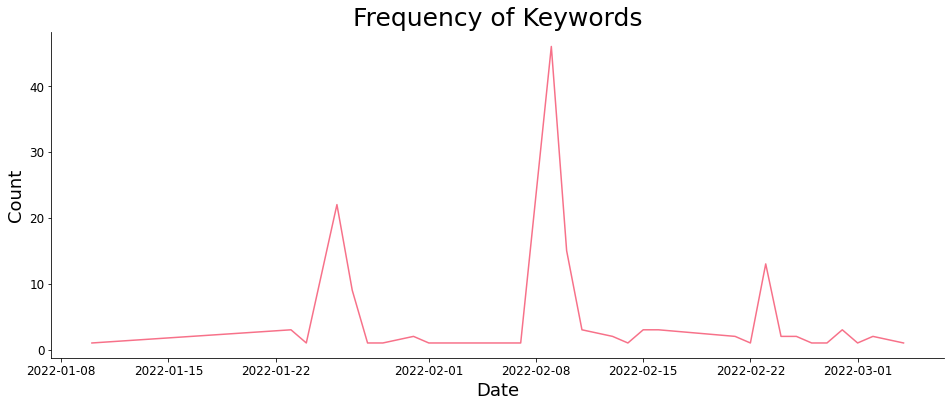

In [162]:
# plot keyword frequency throughout corpus
plt.figure(figsize=(16,6))
sns.set_palette('husl')
fig = sns.lineplot(x=count_dates.index, y=count_dates.values, palette='rocket')
plt.title('Frequency of Keywords', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.spines['right'].set_visible(False)
fig.spines['top'].set_visible(False)
plt.show()

### 2.4.2. Tweet Selection from Keyword(s)

In [163]:
keywords = [['pope', 'francis'],
            ['harris', 'poland'],
            ['invade', 'olympics'],
            ['fly', 'zone'],
            ['abramovich', 'chelsea'],
            ['nord', 'germany'],
            ['separatist', 'putin'],
            ['false', 'flag'],
            ['block', 'facebook'],
            ['biden', 'deploy']]

##### Sources for Reference Summaries

- pope francis: https://www.vaticannews.va/en/pope/news/2022-03/pope-francis-ukraine-war-inhuman-sacrilegious.html
- harris poland: https://www.cnn.com/2022/03/04/politics/kamala-harris-romania-poland/index.html
- nato join: https://www.washingtonpost.com/world/2022/02/01/what-is-nato-treaty-article-five-russia-ukraine/ 
- fly zone: https://abcnews.go.com/International/ukraine-fly-zone-option-experts/story?id=83164297 
- abramovich, chelsea: https://www.cnbc.com/2022/03/02/russian-oligarch-abramovich-says-he-will-sell-chelsea-soccer-club-amid-ukraine-furor.html 
- nord, germany: https://www.cnn.com/2022/02/22/business/nord-stream-2-germany-russia/index.html
- separatist, putin: https://www.pbs.org/newshour/politics/putin-recognizes-separatist-eastern-ukrainian-regions-paving-the-way-for-military-support  
- false, flag: https://www.pbs.org/newshour/world/u-s-intel-suggests-russia-is-plotting-false-flag-attack-in-ukraine-as-pretext-for-invasion
- block, facebook: https://www.theguardian.com/world/2022/mar/04/russia-completely-blocks-access-to-facebook-and-twitter 
- biden, deploy: https://abcnews.go.com/Politics/biden-orders-us-troop-deployments-reassure-nato-allies/story?id=82622507 

In [164]:
ref_sum_ = [["Pope Francis calls the war in Ukraine an act of violent aggression and a sacrilege without justification, and appeals for an end to the violence and long-term welcome of Ukrainian refugees."],
            ["The White House confirmed Friday that Vice President Kamala Harris will pay a visit to NATO allies Poland and Romania next week"],
            ["Senior Chinese officials told senior Russian officials in early February not to invade Ukraine before the end of the Winter Olympics in Beijing"],
            ["Ukrainian officials under relentless attack from Russian forces have pleaded with President Joe Biden and members of NATO to impose a no-fly zone over significant parts of Ukraine."],
            ["Russian oligarch Roman Abramovich said he will sell the Chelsea soccer club in England, a dramatic move that comes in response to outrage over Russia’s invasion of Ukraine. Abramovich at the same time announced that he has instructed the renowned team to set up a foundation that will use all net proceeds from the sale of Chelsea to benefit all victims of the war in Ukraine."],
            ["Germany said it was halting certification of the Nord Stream 2 gas pipeline following Moscow's actions in eastern Ukraine on Monday."],
            ["Russian President Vladimir Putin on Monday recognized the independence of separatist regions in eastern Ukraine and paved the way to provide them military support — triggering threatened new sanctions from the U.S. and Europe and further fueling fears that Russia could imminently invade Ukraine."],
            ["U.S. intel suggests Russia is plotting false flag attack in Ukraine as pretext for invasion. The U.S. accused the Kremlin on Thursday of an elaborate plot to fabricate an attack by Ukrainian forces that Russia could use as a pretext to take military action against its neighbor. Pentagon spokesman John Kirby said the scheme included production of a graphic propaganda video that would show staged explosions and use corpses and actors depicting grieving mourners."],
            ["Russia has completely blocked access to Facebook in retaliation for the platform placing restrictions on state-owned media. The Russian state communications regulator, Roskomnadzor, later said it had also restricted access to Twitter."],
            ["President Joe Biden has ordered U.S. troop deployments to reassure NATO allies amid the standoff with Russia over Ukraine."]]
  
# clean reference summaries
ref_sum = []
punkt = ['.',',','_','/','-','–','—']
for i in ref_sum_:
  for j in i:
    j = j.split()
    j = [item.strip() for item in j if item.strip() not in punkt]
    j = " ".join([word.lower() for word in j])

    ref_sum.append(j)
ref_sum


['pope francis calls the war in ukraine an act of violent aggression and a sacrilege without justification, and appeals for an end to the violence and long-term welcome of ukrainian refugees.',
 'the white house confirmed friday that vice president kamala harris will pay a visit to nato allies poland and romania next week',
 'senior chinese officials told senior russian officials in early february not to invade ukraine before the end of the winter olympics in beijing',
 'ukrainian officials under relentless attack from russian forces have pleaded with president joe biden and members of nato to impose a no-fly zone over significant parts of ukraine.',
 'russian oligarch roman abramovich said he will sell the chelsea soccer club in england, a dramatic move that comes in response to outrage over russia’s invasion of ukraine. abramovich at the same time announced that he has instructed the renowned team to set up a foundation that will use all net proceeds from the sale of chelsea to benef

### 2.4.3. Generate System Summaries

In [165]:
# define abstractive summarizer - T5 Model
summarizer = pipeline("summarization", model="t5-small", tokenizer='t5-base', framework='tf')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [168]:
# generate summaries
sys_sum = []
for i in range(len(keywords)): 
  tweets_keyword = tweets.loc[tweets['tokenized'].apply(lambda x: all([y in x for y in keywords[i]]))]
  tweets_keyword = tweets_keyword[:400:4]
  combined_tweets = "".join([tweet for tweet in tweets_keyword['content_clean']])
  sum = summarizer(combined_tweets, max_length=200, min_length=25)
  sys_sum.append(sum)
  print(f'Completed Summary {i+1} of {len(keywords)}')
print('\n')
sys_sum = [sum_text[0]['summary_text'] for sum_text in sys_sum]
sys_sum

### 2.4.4. Evaluate Summaries with Rouge

In [120]:
# evaluate with Rouge-1
rouge_scores = []
rouge = Rouge()
for elem in range(len(keywords)):
  score = rouge.get_scores(sys_sum[elem], ref_sum[elem])
  rouge_scores.append(score)
rouge_scores

[[{'rouge-1': {'f': 0.3478260822600295,
    'p': 0.27906976744186046,
    'r': 0.46153846153846156},
   'rouge-2': {'f': 0.12499999531250018, 'p': 0.1, 'r': 0.16666666666666666},
   'rouge-l': {'f': 0.26086956052089905,
    'p': 0.20930232558139536,
    'r': 0.34615384615384615}}],
 [{'rouge-1': {'f': 0.22222221739369008, 'p': 0.1875, 'r': 0.2727272727272727},
   'rouge-2': {'f': 0.033333328783333956,
    'p': 0.02564102564102564,
    'r': 0.047619047619047616},
   'rouge-l': {'f': 0.22222221739369008,
    'p': 0.1875,
    'r': 0.2727272727272727}}],
 [{'rouge-1': {'f': 0.32835820489195816,
    'p': 0.22916666666666666,
    'r': 0.5789473684210527},
   'rouge-2': {'f': 0.25581394968090865, 'p': 0.171875, 'r': 0.5},
   'rouge-l': {'f': 0.32835820489195816,
    'p': 0.22916666666666666,
    'r': 0.5789473684210527}}],
 [{'rouge-1': {'f': 0.28947367962950143,
    'p': 0.22448979591836735,
    'r': 0.4074074074074074},
   'rouge-2': {'f': 0.06122448580383199,
    'p': 0.04225352112676056,


In [121]:
# select Rouge recall
rouge_1_recall = [rouge_scores[i][0]['rouge-1']['r'] for i in range(len(rouge_scores))]
rouge_1_recall

[0.46153846153846156,
 0.2727272727272727,
 0.5789473684210527,
 0.4074074074074074,
 0.48936170212765956,
 0.3333333333333333,
 0.3333333333333333,
 0.2786885245901639,
 0.3793103448275862,
 0.35]

In [122]:
# get average Rouge score
mean(rouge_1_recall)

0.3884647748306271